<a href="https://colab.research.google.com/github/erickbonas/projetofinal/blob/main/analise_descritiva_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baixando Arquivos

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"erickbonifaciobello","key":"83ea173a21a1480a84351e3b1e475891"}'}

In [ ]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! mkdir dataset

In [ ]:
! kaggle competitions download -c fake-news-pair-classification-challenge -p '/content/dataset'

 72% 25.0M/34.6M [00:00<00:00, 66.6MB/s]
100% 34.6M/34.6M [00:00<00:00, 88.7MB/s]


In [ ]:
! unzip '/content/dataset/fake-news-pair-classification-challenge.zip' -d '/content/dataset'

Archive:  /content/dataset/fake-news-pair-classification-challenge.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


In [ ]:
! pip install neattext

     |████████████████████████████████| 112kB 6.7MB/s 


## Tratamento de dados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import neattext as nt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
np.random.seed(1082141) 

In [ ]:
def formataTexto(text): 
    text = text.lower()
    text = nt.remove_stopwords(text)
    text = nt.remove_puncts(text)
    text = nt.remove_html_tags(text)
    text = nt.remove_special_characters(text)
    return text

In [ ]:
def freq(str):
  
    # break the string into list of words
    str_list = str.split()
  
    # gives set of unique words
    unique_words = set(str_list)
    lista = []
    for words in unique_words :
        lista.append(str_list.count(words))
        print('Frequency of ', words , 'is :', str_list.count(words))

In [ ]:
training = pd.read_csv('dataset/train.csv')
#training = training.sample(n=50000)
training.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [ ]:
test = pd.read_csv('dataset/test.csv')
test.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en
0,321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...
1,321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...
2,321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...
3,321193,167564,160994,萨达姆被捕后告诫美国的一句话，发人深思,被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！,A message from Saddam Hussein after he was cap...,The hanging Saddam is a surrogate? This man's ...
4,321191,167564,15084,萨达姆被捕后告诫美国的一句话，发人深思,中国川贝枇杷膏在美国受到热捧？纯属谣言！,A message from Saddam Hussein after he was cap...,Chinese loquat loquat plaster in America? Pure...


In [ ]:
#Aplica strip em todas as colunas do dataframe
training = training.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [ ]:
training = training.replace(r'^\s*$', np.nan, regex=True)
training[training.isna().any(axis=1)]

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
7483,7486,3884,7220,2018年土地承包政策的新变动，9亿农民注意了！农民乐开了花！,农村闲置土地真会被收回，这几大问题农民要注意！\n\n \n闲置土地是当前农村土地存在的大问...,The new change of land contract policy in 2018...,NaN,unrelated
48417,48473,21623,42543,不想被打扰，只需要一下就能给手机设置空号，超级简单实用,NaN,"Don't want to be disturbed, just need to be ab...",_,agreed
64150,64312,54820,42543,交警提示：2018年交通部取消蓝牌货车营运证，以后再不怕运管追了,NaN,Traffic sign: The Ministry of Communications w...,_,agreed
220467,220922,113865,42543,朱之文和老婆合唱了这首歌，台下一片沸腾，那英听流泪刀郎听醉了,NaN,Zhu Zuwen and his wife sang this song together...,_,agreed
242810,243368,32190,42543,治疗风湿累风湿的小妙招,NaN,a trick for rheumatism rheumatism,_,agreed
247136,247695,13429,42543,海清闺蜜，最低调女星，曾被蒋勤勤插足恋情，如今41岁仍单身！,NaN,"Haiqing girlfriend, the most low-profile femal...",_,agreed
258958,259536,148869,42543,王健林对赌马云2019房价下跌已马定局，马云，输了我送淘宝,NaN,Wang Jian Lin bet against Ma Yun in 2019 housi...,_,agreed
291175,291779,34114,42543,纳斯达克推出数字货币交易所，手续费全免时代来临,NaN,Nasdaq launches digital currency exchange,_,agreed


In [ ]:
training['label'].value_counts()

unrelated    219313
agreed        92973
disagreed      8266
Name: label, dtype: int64

In [ ]:
# Remove todos os NaN da tabela
training = training.dropna()
training['label'].value_counts()

unrelated    219312
agreed        92966
disagreed      8266
Name: label, dtype: int64

In [ ]:
(training['label'].values=='disagreed').sum()

8266

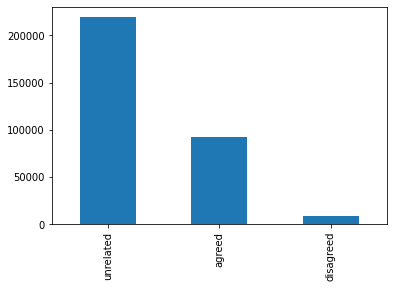

In [ ]:
training['label'].value_counts().plot.bar()

In [ ]:
training['title1EnProcessado'] = training['title1_en'].apply(formataTexto)
training['title2EnProcessado'] = training['title2_en'].apply(formataTexto)
training.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label,title1EnProcessado,title2EnProcessado
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,new oldage insurance benefits old people rural...,police disprove birds nest congress person get...
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,if come shenzhen sooner later son come 10 year...,shenzhens gdp outstrips hong kong shenzhen sta...
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,if come shenzhen sooner later son come 10 year...,gdp overtopped hong kong shenzhen clarified li...
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated,if come shenzhen sooner later son come 10 year...,shenzhens gdp topped hong kong year shenzhen b...
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed,how discriminate oil gutter oil means garlic,took 30 years cooking oil know piece garlic ea...


### Word Cloud

https://www.kaggle.com/tanmaymane18/fake-vs-real-news-text-neattext-logr-99-5

In [ ]:

textTitle1EnProcessado = ' '.join(training['title1EnProcessado'].values)
textTitle2EnProcessado = ' '.join(training['title2EnProcessado'].values)

wordcloudTextTitle1 = WordCloud(width = 1024, height = 800, background_color='black', min_font_size=10).generate(textTitle1EnProcessado)
wordcloudTextTitle2 = WordCloud(width = 1024, height = 800, background_color='black', min_font_size=10).generate(textTitle2EnProcessado)



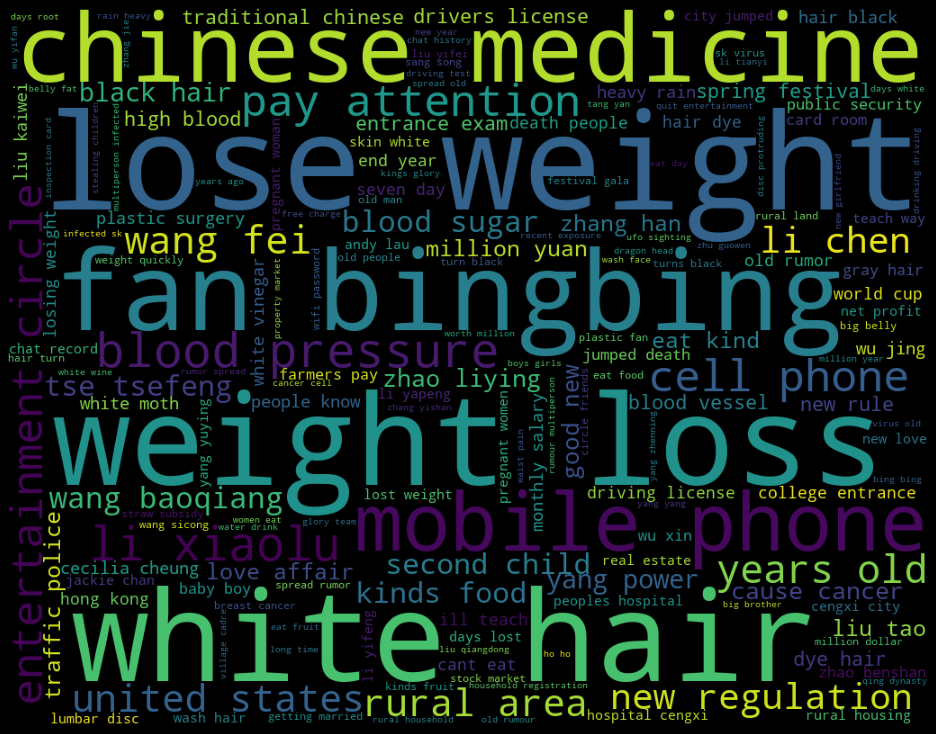

In [ ]:
plt.figure(figsize = (20, 10), facecolor = 'k')
plt.imshow(wordcloudTextTitle1)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

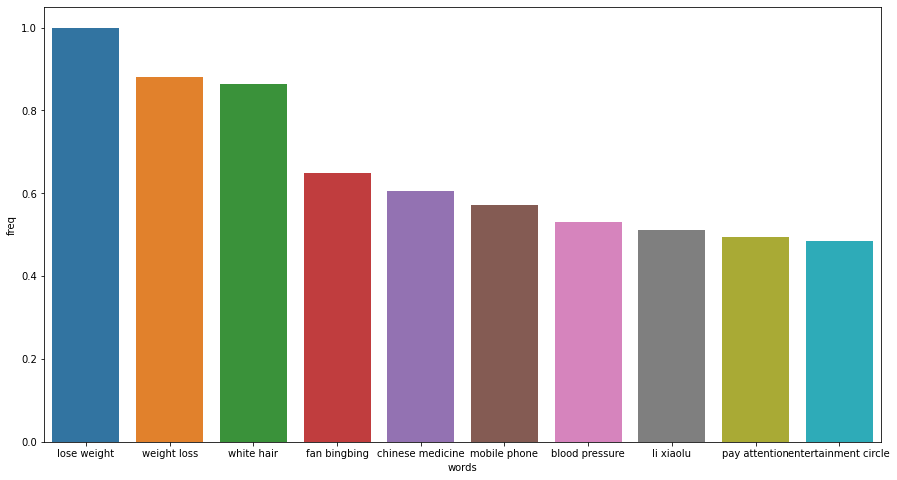

In [ ]:
import seaborn as sns
words, freq = list(wordcloudTextTitle1.words_.keys()), list(wordcloudTextTitle1.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[:10], freq[:10])), columns=['words', 'freq'])
plt.figure(figsize=(15,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])

In [ ]:
txtWords.to_csv('freqTexto1.csv')

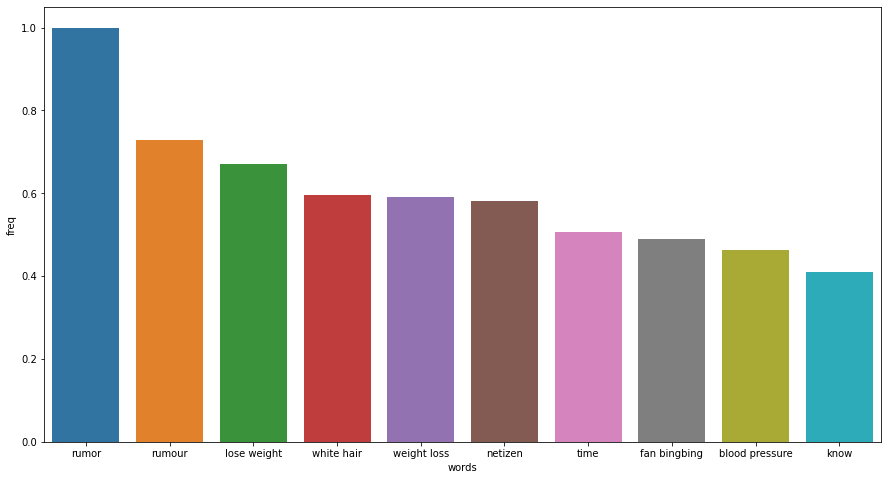

In [ ]:
words, freq = list(wordcloudTextTitle2.words_.keys()), list(wordcloudTextTitle2.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[:10], freq[:10])), columns=['words', 'freq'])
plt.figure(figsize=(15,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])

In [ ]:
txtWords.to_csv('freqTexto2.csv')

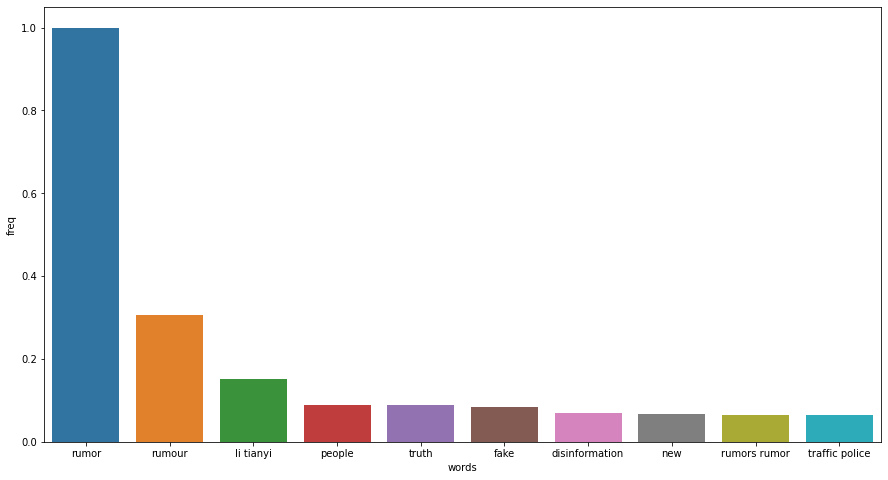

In [ ]:
dfDisagreedTextTitle2 = training[training['label']=='disagreed']
dfDisagreedTextTitle2 = dfDisagreedTextTitle2['title2EnProcessado']

disagreedTextTitle2 = ' '.join(dfDisagreedTextTitle2.values)


wordcloudDisagreedTextTitle2 = WordCloud(width = 1024, height = 800, background_color='black', min_font_size=10).generate(disagreedTextTitle2)

words, freq = list(wordcloudDisagreedTextTitle2.words_.keys()), list(wordcloudDisagreedTextTitle2.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[:10], freq[:10])), columns=['words', 'freq'])
plt.figure(figsize=(15,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])

In [ ]:
txtWords.to_csv('freqTexto2Disagreed.csv')

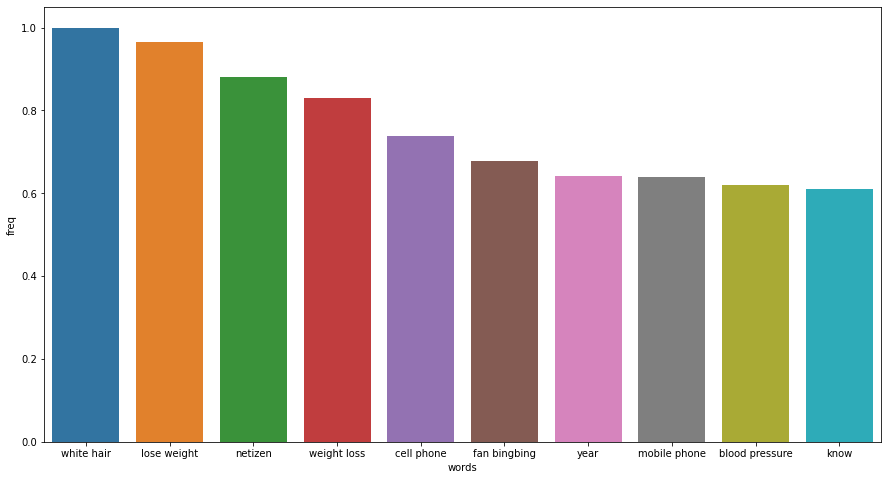

In [ ]:
dfAgreedTextTitle2 = training[training['label']=='agreed']
dfAgreedTextTitle2 = dfAgreedTextTitle2['title2EnProcessado']

AgreedTextTitle2 = ' '.join(dfAgreedTextTitle2.values)


wordcloudAgreedTextTitle2 = WordCloud(width = 1024, height = 800, background_color='black', min_font_size=10).generate(AgreedTextTitle2)

words, freq = list(wordcloudAgreedTextTitle2.words_.keys()), list(wordcloudAgreedTextTitle2.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[:10], freq[:10])), columns=['words', 'freq'])
plt.figure(figsize=(15,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])

In [ ]:
txtWords.to_csv('freqTexto2Agreed.csv')

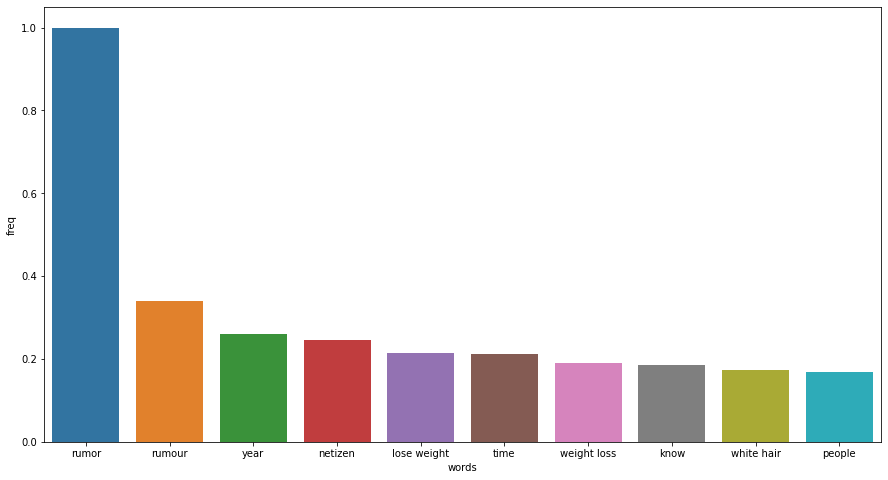

In [ ]:
dfUnrelatedTextTitle2 = training[training['label']=='unrelated']
dfUnrelatedTextTitle2 = dfUnrelatedTextTitle2['title2EnProcessado']

UnrelatedTextTitle2 = ' '.join(dfUnrelatedTextTitle2.values)


wordcloudUnrelatedTextTitle2 = WordCloud(width = 1024, height = 800, background_color='black', min_font_size=10).generate(UnrelatedTextTitle2)

words, freq = list(wordcloudUnrelatedTextTitle2.words_.keys()), list(wordcloudUnrelatedTextTitle2.words_.values())
txtWords = pd.DataFrame(data = list(zip(words[:10], freq[:10])), columns=['words', 'freq'])
plt.figure(figsize=(15,8))
sns.barplot(x=txtWords['words'], y=txtWords['freq'])

In [ ]:
txtWords.to_csv('freqTexto2Unrelated.csv')

# Classificadores

Sugestão colocar uma semente

In [ ]:
df_train, df_val = train_test_split(training[['title1_en', 'title2_en', 'label']], test_size=0.2, shuffle=True)
df_train

,title1_en,title2_en,label
115200,Because of many troublesome character and Li S...,"Once again, Li Tianyi's life was questioned be...",agreed
219732,Do you believe the 7 Great Prophecies of the F...,What are the future of the rural future? Where...,agreed
308138,Oncology expert real-time voice: anti-cancer a...,Dietetic cancer: how to eat the better fruits ...,unrelated
211018,"in spring, the body is dry and desquamated, an...","Body moisture rises in spring, adding it when ...",unrelated
275154,Do not dye the white hair! The starch is so us...,Don't ever dye your hair again. It's practical...,unrelated
...,...,...,...
60478,Jie Yuating in five luxury homes in the US: mo...,700 square meters! Jia Yuating in the beautifu...,unrelated
111775,It's so easy to locate someone's location. Ope...,"To know the exact location of the husband, ope...",agreed
75846,"Constipation 7 days, 1 month? Drinking them on...",Are your chopsticks causing cancer? Three tips...,unrelated
123692,zhou libo carries a maximum sentence of 41 yea...,"Zhou Libo was sentenced to 41 years in prison,...",unrelated


In [ ]:
x_train, x_val = df_train[['title1_en', 'title2_en']], df_val[['title1_en', 'title2_en']]
y_train, y_val = df_train['label'], df_val['label']
x_val

,title1_en,title2_en
292775,"Survival of the Jedi: Yes, Tencent agent for t...","""Survival of the Jedi"" national service line i..."
260634,"Mr Wang openly mocked Mr Ma! Mr Ma, come here ...",Wang Sicong micro- blog tore up Ma: Paypal cha...
99020,Liu Kaiwei issued a letter to accuse the derai...,"""The Power of the Phoenix"" issued a statement ..."
198526,It is said that the characteristics of the gir...,It is said that the characteristics of the gir...
45416,The Three Kingdoms rush to export advanced eng...,MADASHI 3000 Technical Migration? It's a rumou...
...,...,...
33074,"""Smiling A Smile"" 2 ""Shooting, Directing Team'...","When you're in the middle of a crisis, you can..."
290372,"Red dates and it bubble together, a cup every ...","You can turn white one time, and you can bleac..."
293498,"Green card holder, green card, no more than 3 ...","Feng Xiaogang satirizes the rubbish movie of ""..."
71818,the two sides did not reciprocate by restartin...,"Ofo sues anrennet, media benches and others fo..."


In [ ]:
features = 1024

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',
                                        max_features=features),
                        StandardScaler(with_mean=False))

x_train_title1 = encoder.fit_transform(x_train['title1_en']).toarray()
x_val_title1 = encoder.transform(x_val['title1_en']).toarray()

x_train_title2 = encoder.fit_transform(x_train['title2_en']).toarray()
x_val_title2 = encoder.transform(x_val['title2_en']).toarray()

In [ ]:
label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_val = label_enc.transform(y_val)

In [ ]:
label_enc.classes_

array(['agreed', 'disagreed', 'unrelated'], dtype=object)

In [ ]:
x_train = np.concatenate((x_train_title1, x_train_title2), axis=1)
x_val = np.concatenate((x_val_title1, x_val_title2), axis=1)

In [ ]:
training = None
df_train = None
df_val = None
x_train_title1 = None
x_val_title1 = None
x_train_title2 = None
x_val_title2 = None

In [ ]:
x_train.shape

(39997, 1200)

In [ ]:
y_train.shape

(39997,)

## Regressor logistico

In [ ]:
C_range = np.logspace(-3, 2, 5)

lm = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=200, class_weight='balanced')

grid_values = {'penalty': ['l1','l2'], 'C': C_range}
grid_lm = GridSearchCV(lm, param_grid = grid_values, cv=3, scoring = 'accuracy', n_jobs = -1)

grid_lm.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
C_best = grid_lm.best_params_['C']
penalty_best = grid_lm.best_params_['penalty']
g = grid_lm 


In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_lm.best_params_, grid_lm.best_score_))

Melhores parametros encontrados {'C': 0.001, 'penalty': 'l1'} com score de 0.6949


In [ ]:
from sklearn import metrics
import seaborn as sns; sns.set()

def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(10, 8))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)    

Accuracy: 0.697
Accuracy (balanced): 0.493


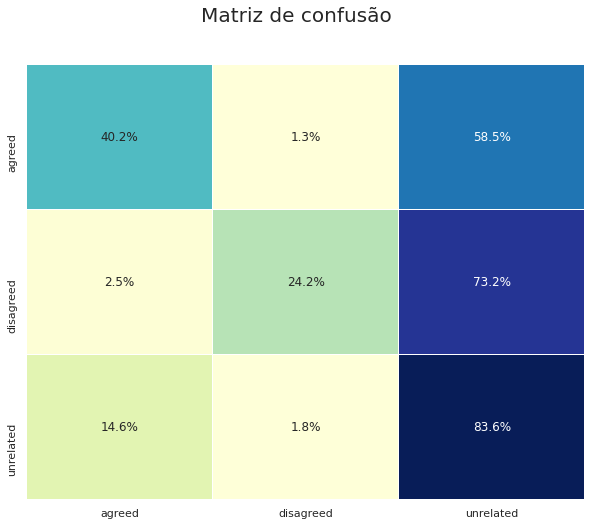

In [ ]:
evaluate(y_val, g.predict(x_val), g.predict_proba(x_val), labels=label_enc.classes_)

## FLORESTA ALEATÓRIA

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(   
    random_state=0, 
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced', 
    max_features=features
)

grid_clf_values = {'max_depth': [5, 10, 15], 'n_estimators': [150, 200]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=1024,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=True, random_state=0,
                                  

In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_clf.best_params_, grid_clf.best_score_))

Melhores parametros encontrados {'max_depth': 10, 'n_estimators': 150} com score de 0.5699


Accuracy: 0.372
Accuracy (balanced): 0.569


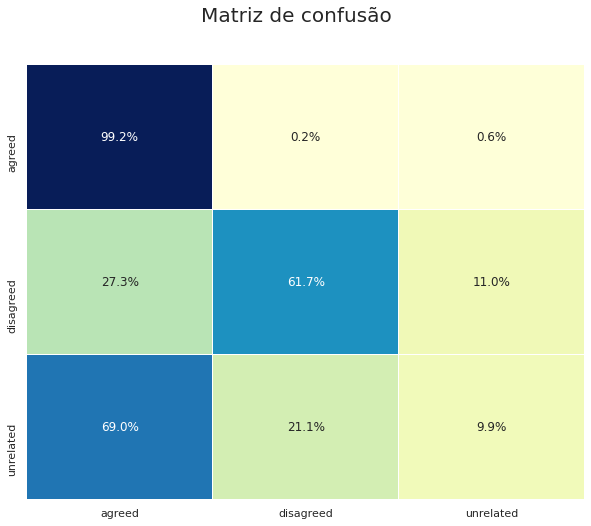

In [ ]:
evaluate(y_val, grid_clf.predict(x_val), grid_clf.predict_proba(x_val), labels=label_enc.classes_)

## Redes Neurais

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input, InputLayer, Dropout
from keras import optimizers, callbacks

In [ ]:
epochs = 20
batch_size = 128
input_shape = [features]

In [ ]:
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=3)
y_ohe_val = np_utils.to_categorical(ye_val, num_classes=3)

In [ ]:
model = Sequential([
InputLayer((1024,)),
Dense(1024, activation="relu"),
Dense(256, activation = "relu"),
Dense(6, activation="softmax")
])

model.compile(optimizer='sgd',
loss='categorical_crossentropy',
# metrics=['accuracy'])
metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

model.summary()



1.   Fazer tfidf usando os bigramas 
2.   Fazer o SMOTEEN antes de utilizar os classificadores
3.   Rodar novamente os classificadores 
4.   Estudar como usar o hub para classificação de sentimento em textos  https://www.tensorflow.org/tutorials/keras/text_classification_with_hub, https://tfhub.dev/google/universal-sentence-encoder/4
5.   Fazer uma rede normal
6.   Estudar redes siamesas https://keras.io/examples/vision/siamese_contrastive/

Se der tempo 
1. Estudar BERT ( arquitetura moderna para processamento ) 
    https://www.tensorflow.org/text/tutorials/classify_text_with_bert
2. https://huggingface.co/transformers/
3. Aumentação de texto https://arxiv.org/pdf/1901.11196.pdf

5.   Procurar alguma rede pronta como https://tfhub.dev/google/nnlm-en-dim128/2

Uma última dica: tem uma outra formulação para problemas de matching que nós chamamos de metric learning.
O objetivo desse tipo de aprendizado é mapear objetos não-estruturados (ex frases) em um espaço que preserve a relação de contraste entre eles (ex: frases que concordam próximas/frases que discordam distantes).
Nesse tipo de aprendizado, você tem uma rede siamesa (com duas entradas) e uma saída (se as entradas são ou não similares).
Você poderia treinar esse modelo pra identificar se duas frases concordam ou não.
Exemplo no tensorflow: https://keras.io/examples/vision/siamese_contrastive/